In [1]:
#package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

In [3]:
test_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [4]:
# Separate success/fail sets
pizza = training_data[training_data['requester_received_pizza'] == True]
no_pizza = training_data[training_data['requester_received_pizza'] == False]
no_pizza_short = no_pizza[:len(pizza)]

# Create new dataframe with equal outcomes
new_train = pd.concat([pizza, no_pizza_short], axis = 0)
new_train = new_train.sample(frac=1) # shuffle
new_train.reset_index()
new_train['requester_received_pizza'] = new_train['requester_received_pizza'].astype(int) # boolean to 0/1

# Split data and set the appropriate columns
test_features = test_data.columns
Y = new_train['requester_received_pizza']
X = new_train[training_data.columns[training_data.columns.isin(test_features)]]

# Split for train and validation
val_split = int(len(new_train) * 0.9)
train_data, train_labels = X[:val_split], Y[:val_split]
val_data, val_labels = X[val_split:], Y[val_split:]


# Get only request text
train_requests = train_data['request_text_edit_aware'].str.lower().tolist()
val_requests = val_data['request_text_edit_aware'].str.lower().tolist()

## Data pre-processing

In [5]:
# Append request length
def req_length(data):
    req_lens = []
    for request in data['request_text_edit_aware']:
        req_lens.append(len(request.split()))
    
    data['req_len'] = req_lens
    
    return data

In [6]:
# Append title length
def title_length(data):
    title_lens = []
    for title in data['request_title']:
        title_lens.append(len(title.split()))
    
    data['title_len'] = title_lens
    
    return data

In [7]:
# Bag of words
money = ['money',
        'rent',
        'broke',
        'paid',
        'spent',
        'bills',
        'paycheck',
        'payment',
        'struggle',
        'landlord',
        'debt',
        'unexpected',
        'dollars',
        'budget',
        'stamps',
        'check',
        'month',
        'week',
        'mon',
        'tues',
        'wed',
        'thurs',
        'fri',
        'accident',
        'car',
        'hospital',
        'medical',
        ]

hunger = ['food',
        'hungry',
        'starving',
        'starve',
        'empty',
        'ramen',
        'nothing',
        'eaten',
        'belly',
        'stomach',
        'fridge',
        'cupboard',
        'leftovers',
        'groceries',
        'pantry',
        'meal']

unemployed = ['job',
            'work',
            'unemployed',
            'laid off',
            'fired',
            'grad',
            'interview',
            'application']

gratitude = ['thank',
            'kind',
            'pay it forward',
            'give back',
            'sincere',
            'promise',
            'thanks',
            'help',
            'great',
            'hey']

word_bags = {'money': money, 
             'hunger': hunger, 
             'unemployed': unemployed,
             'thanks': gratitude}

In [8]:
def encode_one_hot(text, data):
    '''Checks for words in the text request for a given dataframe, returns the encoding list'''
    one_hot = []
    requests = data['request_text_edit_aware'].str.lower().tolist()
    
    for i in range(len(data)):
        check = []

        for word in text:
            if word in requests[i]:
                check.append(True)
                break
            else:
                check.append(False)
            
        if any(check):
            one_hot.append(1)
        else:
            one_hot.append(0)

    
    return one_hot

In [9]:
def add_one_hots(bags, df):
    '''Takes the encoding list and adds columns to the passed dataframe, returns modified df'''
    for bag in bags:
        col_name = bag
        bag_one_hots = encode_one_hot(bags[col_name], df)
        df[col_name] = bag_one_hots
    
    return df

In [10]:
# Add the new features to training data
train_data = req_length(train_data)
train_data = title_length(train_data)
train_data = add_one_hots(word_bags, train_data)

# Add the new features to training data to validation data
val_data = req_length(val_data)
val_data = title_length(val_data)
val_data = add_one_hots(word_bags, val_data)

In [11]:
train_data.head()

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,req_len,title_len,money,hunger,unemployed,thanks
2369,N/A,t3_qktdu,"First time here, I have been living off of can...","[Request] -Edmonton, Canada - Broke College Ki...",127.601169,0.00000,33,0,3,0,...,272,meonhere,1331074745,1331074745,35,11,0,1,0,1
764,photo,t3_krb3m,"I'm not complaining or anything, I'm sure I'll...",[REQUEST] separated from the military in augus...,285.569595,0.00000,229,0,25,0,...,1621,jnorthup0620,1317000679,1316997079,45,17,1,1,0,0
1331,N/A,t3_1mc3ss,Nothing too special. Just packing and craving ...,"[Request] (Idaho) packing up my apartment, nee...",663.453669,150.84125,205,3,55,2,...,17783,IdahoSucks,1379106713,1379103113,8,8,0,1,0,0
38,N/A,t3_z7i07,"Hey RAoP,\n\nMy situation is that I just finis...","[REQUEST] San Jose, California - AmeriCorps al...",0.000000,0.00000,0,0,0,0,...,0,hungrycorpsteacher,1346548629,1346545029,159,28,1,1,1,1
167,N/A,t3_m3nk7,"So, I [wrote](http://www.reddit.com/r/unitedki...",[REQUEST] I feel really embarrassed asking but...,269.880648,0.00000,0,0,7,0,...,400,AwhMan,1320684933,1320684933,221,19,1,1,0,1


In [12]:
# Use only specific features
tree_features = ['requester_account_age_in_days_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_upvotes_plus_downvotes_at_request',
                'req_length',
                'title_length',
                'money',
                'hungry',
                'thanks',
                'job']

tr_train = train_data[train_data.columns[train_data.columns.isin(tree_features)]]
tr_val = val_data[val_data.columns[val_data.columns.isin(tree_features)]]

Using a decision stump -- a tree with depth 4:
Feature importances: [0.1788707  0.27964121 0.36737474 0.         0.17411334]
Validation Accuracy: 0.5376884422110553


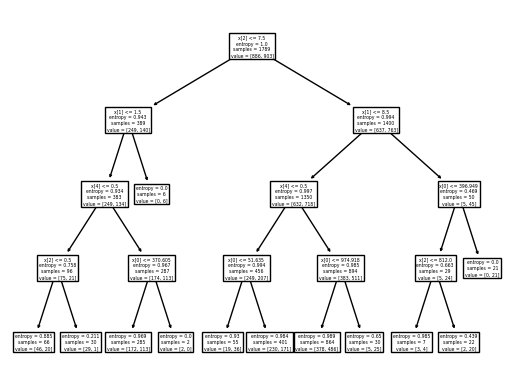

In [13]:
# Set classifier and fit for decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(tr_train, train_labels)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 4:')
print ('Feature importances:', dt.feature_importances_)
print ('Validation Accuracy:', dt.score(tr_val, val_labels))

In [14]:
# Set classifier
forest = RandomForestClassifier(n_estimators = 50)

# Fit the model
forest.fit(tr_train, train_labels)

# Get accuracies
print ('Training Accuracy:', forest.score(tr_train, train_labels))
print ('Validation Accuracy:', forest.score(tr_val, val_labels))

Training Accuracy: 0.9351593068753493
Validation Accuracy: 0.5979899497487438


In [15]:
# Check confusion matrix on predictions
rf_val_predictions = forest.predict(tr_val)

pd.DataFrame(confusion_matrix(val_labels, rf_val_predictions))

,0,1
0,68,40
1,40,51


In [16]:
# Show the classification report
print(classification_report(val_labels, rf_val_predictions))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       108
           1       0.56      0.56      0.56        91

    accuracy                           0.60       199
   macro avg       0.60      0.60      0.60       199
weighted avg       0.60      0.60      0.60       199



In [17]:
# Check requests for correct vs. incorrect predictions

# Check true
val_labels[:10]

1163    0
877     0
793     1
730     0
498     1
978     0
525     1
292     1
155     0
1945    1
Name: requester_received_pizza, dtype: int64

In [18]:
# Check predictions
rf_val_predictions[:10]

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1])

In [19]:
val_data[:10]

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,...,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,req_len,title_len,money,hunger,unemployed,thanks
1163,N/A,t3_zuoiz,Just passed the last check ride in order to ge...,[request] pizza in Bend Or in celebration of h...,23.044456,0.000000,75,0,11,0,...,456,P38sheep,1347587198,1347583598,56,11,1,0,1,0
877,N/A,t3_j0aex,"Now, I'm not a poor guy. My family makes money...",[request] Healthy food? Fuck that.,608.777731,0.000000,11,0,4,0,...,81,Raiden1312,1311702230,1311698630,95,5,1,1,0,1
793,the_jury_is_out,t3_veeyw,"Hey guys, I just got back from the vet after m...",[Request] Spent the last of my money paying th...,546.925359,0.000000,53,0,5,0,...,225,carltonbankz,1340314888,1340311288,75,21,1,1,0,1
730,N/A,t3_ji3ev,"The roommate's out, the boyfriend's having a n...","[REQUEST]Alone on a Saturday night, will make ...",10.876377,0.000000,0,0,5,0,...,320,___VK,1313286648,1313283048,177,16,1,1,1,1
498,N/A,t3_toxi0,I have a couple babysitting gigs lined up next...,"[request] college student, just started first ...",235.988056,0.000000,39,0,15,0,...,277,STHOA,1337123667,1337120067,79,20,1,0,0,1
978,N/A,t3_k3x4v,with my best friend and haven't eaten a full m...,[REQUEST]stranded in denver...,0.000000,0.000000,0,0,0,0,...,0,tiger_lily87,1315097555,1315093955,30,3,1,1,0,0
525,N/A,t3_hw5vx,So I had an ex-roommate who owed me a portion ...,[request] Have had a run of bad luck in the la...,118.827593,0.000000,103,0,17,0,...,508,NerdWith_A_Tan,1307687703,1307684103,524,19,1,1,1,1
292,N/A,t3_mpdzz,"Hello! Normally we would never do this, but we...",[Request] Hungry Couple in Minneapolis,0.000000,0.000000,0,0,0,0,...,9,HungryCouple,1322267835,1322267835,153,5,1,0,0,1
155,N/A,t3_1ln1oz,I quit my job to go abroad for 30 days. Not t...,[REQUEST] Due to poor decision making I had to...,888.237650,241.865370,968,3,134,1,...,14323,DrFeargood,1378215816,1378212216,134,22,1,0,1,1
1945,N/A,t3_kte8z,ive asked yesterday and got nothing and i just...,[REQUEST] hungry broke and willing to pizza i...,35.723611,35.723611,24,24,2,2,...,66,draco619,1317163669,1317160069,21,10,0,1,0,0


In [20]:
val_requests[:10]

["just passed the last check ride in order to get my license next week, big day! anyway it's all paid for through the military, so i don't have a job/money to by my own pizza. if your in bend or want to come to bend i will give you a ride in a helicopter, for free.",
 "now, i'm not a poor guy. my family makes money, we live well.\nhowever.\nmy family has recently been on a healthy food kick. i'm all for eating healthy, but i like to indulge every once in a while. they're not a fan of doing that. i'd go to the store and get something, but whoops no license. i'd order a pizza, but i have about ten bucks to my name and i have plans for that money. so just pm me if you want to send a pizza to a guy in central florida. ",
 "hey guys, i just got back from the vet after my kitten had an accident, poor guy broke his paw. i don't earn much and scrap by every week with my food budget and the veterinarian bill really set me back this week. if someone here could help me out it would really put my 

## Test predictions

In [21]:
# Process the test data
test_data = req_length(test_data)
test_data = title_length(test_data)
test_data = add_one_hots(word_bags, test_data)
tr_test = test_data[test_data.columns[test_data.columns.isin(tree_features)]]

In [22]:
# Get the predictions from the models
#test_predictions = dt.predict(tr_test)
rf_test_predictions = forest.predict(tr_test)

In [23]:
def get_submission_csv(predictions):
    '''Takes predictions and creates dictionary and df for csv export'''
    test_ids = test_data['request_id']
    
    d = {'request_id': test_ids,
    'requester_received_pizza': predictions}
    
    df = pd.DataFrame(data=d)
    df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
    
    return df

In [24]:
# Create the df
df = get_submission_csv(rf_test_predictions)

In [26]:
# Export to csv
# df.to_csv('rf_model.csv', index=False)